In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
import scipy.stats as spstat
import time

from conquer.linear_model import low_dim, high_dim, cv_lambda, validate_lambda

def cov_generate(std, corr=0.5):
    p = len(std)
    R = np.zeros(shape=[p,p])
    for j in range(p-1):
        R[j, j+1:] = np.array(range(1, len(R[j,j+1:])+1))
    R += R.T
    return np.outer(std, std)*(corr*np.ones(shape=[p,p]))**R

rgt.seed(1)

The reference machine used for the simulations below is a Mac Pro with a 3.2 GHz 16-Core Intel Xeon processor and 96 GB of RAM. Each simulation exploits only one processor, without any parallelism.

## Model 1

Let $z=(z_1, \ldots, z_p)^T \sim N(0, \Sigma)$ with $\Sigma = (0.5^{|j-k|})_{1\leq j, k \leq p}$. Generate independent data vectors $\{(y_i , x_i) \}_{i=1}^n$ from the model $y_i =   \langle x_i, \beta^*  \rangle    + 0.7 x_{i1}  \varepsilon_i$, where $x_i = (x_{i1}, \ldots, x_{ip})^T \sim (\Phi(z_1), z_2, \ldots, z_p)^T$, $\varepsilon_i \sim N(0,1)$ are independent of $x_i$, and $\beta^* \in \mathbb R^p$ is sparse with $\beta^*_6 = \beta^*_{12} =\beta^*_{15} = \beta^*_{20} =1$.

Consider two quantile levels: $\tau=0.5$ and $\tau=0.7$. Note that the effect of $x_{i1}$ is only present for $\tau=0.7$.

In [2]:
n, p = 300, 1000
Mu, Sig = np.zeros(p), cov_generate(np.ones(p))
beta = np.zeros(p)
beta[[5, 11, 14, 19]] = 1

M = 100
coef_err = np.zeros(shape=(M,3))
tp = np.zeros(shape=(M,3))
fp = np.zeros(shape=(M,3))

### Case 1: $\tau=0.5$.

In [3]:
tau = 0.5
true_beta = np.copy(beta)
true_beta[0] = 0.7*spstat.norm.ppf(tau)
true_set = np.where(true_beta!=0)[0]

runtime = np.zeros(3)
for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    X[:,0] = spstat.norm.cdf(X[:,0])
    Y = X.dot(beta) + 0.7*X[:,0]*rgt.normal(0,1,size=n)

    sqr = high_dim(X, Y, intercept=False)
    sim_lambda = np.quantile(sqr.self_tuning(tau), 0.95)
    
    ## l1-penalized conquer (l1 conquer)
    tic = time.time()
    l1_model = sqr.l1(tau, 0.7*sim_lambda)
    runtime[0] += time.time() - tic

    ## Iteratively reweighted l1-penalized conquer (IRW-l1 conquer)
    tic = time.time()
    irw_model = sqr.irw(tau, 0.7*sim_lambda)
    runtime[1] += time.time() - tic

    ## Oracle conquer
    tic = time.time()
    ora_model = low_dim(X[:,true_set], Y, intercept=False).fit(tau=tau)
    runtime[2] = runtime[2] + time.time() - tic
    
    est = np.c_[(l1_model['beta'], irw_model['beta'], np.zeros(p))]
    est[:,2][beta!=0] = ora_model['beta']
    est = pd.DataFrame(est)

    coef_err[m,:] = (est - beta[:,None]).pow(2).sum(axis=0) 
    tp[m,:] = (est.ne(0) * (beta!=0)[:,None]).sum(axis=0) 
    fp[m,:] = (est.ne(0) * (beta==0)[:,None]).sum(axis=0)
    
out1 = pd.DataFrame(np.array([np.mean(coef_err, axis=0), np.std(coef_err, axis=0), np.mean(tp, axis=0), np.mean(fp, axis=0), runtime/M]),
                    columns=['l1-conquer', 'irw-conquer', 'oracle-conquer'],
                    index=['coef err', '(std)', 'true pos', 'false pos', 'runtime'])
print(out1)
print('\nX1 selection rate:', np.mean(tp[:,1]==5))

           l1-conquer  irw-conquer  oracle-conquer
coef err     0.033260     0.001097        0.000977
(std)        0.010645     0.000816        0.000741
true pos     4.000000     4.000000        4.000000
false pos    0.280000     0.050000        0.000000
runtime      0.021698     0.027951        0.003408

X1 selection rate: 0.0


### Case 2: $\tau=0.7$.

In [4]:
tau = 0.7
true_beta = np.copy(beta)
true_beta[0] = 0.7*spstat.norm.ppf(tau)
true_set = np.where(true_beta!=0)[0]

runtime = np.zeros(3)
for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    X[:,0] = spstat.norm.cdf(X[:,0])
    Y = X.dot(beta) + 0.7*X[:,0]*rgt.normal(0,1,size=n)

    sqr = high_dim(X, Y, intercept=False)
    sim_lambda = np.quantile(sqr.self_tuning(tau), 0.95)
    
    ## l1-penalized conquer (l1 conquer)
    tic = time.time()
    l1_model = sqr.l1(tau, 0.7*sim_lambda)
    runtime[0] += time.time() - tic

    ## Iteratively reweighted l1-penalized conquer (IRW-l1 conquer)
    tic = time.time()
    irw_model = sqr.irw(tau, 0.7*sim_lambda)
    runtime[1] += time.time() - tic

    ## Oracle conquer
    tic = time.time()
    ora_model = low_dim(X[:,true_set], Y, intercept=False).fit(tau=tau)
    runtime[2] = runtime[2] + time.time() - tic
    
    est = np.c_[(l1_model['beta'], irw_model['beta'], np.zeros(p))]
    est[:,2][true_beta!=0] = ora_model['beta']
    est = pd.DataFrame(est)

    coef_err[m,:] = (est - true_beta[:,None]).pow(2).sum(axis=0) 
    tp[m,:] = (est.ne(0) * (true_beta!=0)[:,None]).sum(axis=0) 
    fp[m,:] = (est.ne(0) * (true_beta==0)[:,None]).sum(axis=0)

out2 = pd.DataFrame(np.array([np.mean(coef_err, axis=0), np.std(coef_err, axis=0), np.mean(tp, axis=0), np.mean(fp, axis=0), runtime/M]),
                    columns=['l1-conquer', 'irw-conquer', 'oracle-conquer'],
                    index=['coef err', '(std)', 'true pos', 'false pos', 'runtime'])
print(out2)
print('\nX1 selection rate:', np.mean(tp[:,1]==5))

           l1-conquer  irw-conquer  oracle-conquer
coef err     0.034493     0.005991        0.005363
(std)        0.013485     0.006118        0.005291
true pos     5.000000     5.000000        5.000000
false pos    0.270000     0.010000        0.000000
runtime      0.048075     0.060758        0.001890

X1 selection rate: 1.0


## Model 2

Construct the covariance matrix $\Sigma = (\sigma_j \sigma_k 0.5^{|j-k|})_{1\leq j, k \leq p}$, where $\sigma_1, \ldots, \sigma_p$ are independently generated from Unif$(1,2)$.
Generate independent data vectors $\{(y_i , x_i) \}_{i=1}^n$ from the model $y_i =  4 + \langle x_i, \beta^*  \rangle    +   \varepsilon_i - F_{ \varepsilon_i}^{-1}(\tau)$, where $x_i \sim N(0, \Sigma)$ and $\varepsilon_i \sim t_2$ are independent, and $\beta^* \in \mathbb R^p$ is sparse.

In [5]:
n, p = 256, 1028
tau = 0.75
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
itcp, beta = 4, np.zeros(p)
beta[:15] = [1.6, 0, 1.4, 0, 1.2, 0, 1, 0, -1, 0, -1.2, 0, -1.4, 0, -1.6]
true_set = np.where(beta!=0)[0]
true_loc = np.zeros(p)
true_loc[true_set] = 1

### 2.1. Simulation results for $\ell_1$- and iteratively reweighted $\ell_1$-penalized conquer

The penality level $\lambda>0$ is determined by a simulation-based method.

In [6]:
M = 100
runtime = np.zeros(3)
itcp_err, coef_err = np.zeros(shape=(M,3)), np.zeros(shape=(M,3))
tp, fp = np.zeros(shape=(M,3)), np.zeros(shape=(M,3))

for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp*np.ones(n) + X.dot(beta) + rgt.standard_t(2,size=n) - spstat.t.ppf(tau,df=2)
 
    sqr = high_dim(X, Y)
    sim_lambda = np.quantile(sqr.self_tuning(tau), 0.95)

    ## l1-penalized conquer
    tic = time.time()
    l1 = sqr.l1(tau=tau, Lambda=0.7*sim_lambda)
    runtime[0] += time.time() - tic

    ## Iteratively reweighted l1-penalized conquer (default is SCAD penality)
    tic = time.time()
    irw = sqr.irw(tau=tau, Lambda=0.7*sim_lambda)
    runtime[1] += time.time() - tic

    ## Oracle conquer
    tic = time.time()
    sqr = low_dim(X[:,true_set], Y)
    ora = sqr.fit(tau=tau)
    runtime[2] += time.time() - tic
    
    est = np.c_[(l1['beta'], irw['beta'], np.zeros(p+1))]
    est[0,2], est[1:,2][beta!=0] = ora['beta'][0], ora['beta'][1:]
    est = pd.DataFrame(est)
    
    itcp_err[m,:] = (est.iloc[0] - itcp).abs()
    coef_err[m,:] = (est.iloc[1:] - beta[:,None]).pow(2).sum(axis=0)
    tp[m,:] = (est.iloc[1:].ne(0) * (beta!=0)[:,None]).sum(axis=0)
    fp[m,:] = (est.iloc[1:].ne(0) * (beta==0)[:,None]).sum(axis=0)
    
table = {'itcp err':   np.mean(itcp_err, axis=0), '(itcp std)': np.std(itcp_err, axis=0), 
         'coef err':   np.mean(coef_err, axis=0), '(coef std)': np.std(coef_err, axis=0),
         'true pos':   np.mean(tp, axis=0), 
         'false pos':  np.mean(fp, axis=0), 
         'runtime':    runtime/M} 
pd.DataFrame(table, index=['l1', 'irw-l1','oracle'])

,itcp err,(itcp std),coef err,(coef std),true pos,false pos,runtime
l1,0.504625,0.260449,0.831558,0.471418,8.0,3.39,0.143025
irw-l1,0.100087,0.076383,0.063528,0.054726,8.0,1.53,0.157032
oracle,0.096015,0.073387,0.053439,0.036196,8.0,0.00,0.003817


### 2.2. Solution paths of $\ell_1$- and iteratively reweighted $\ell_1$-penalized conquer

In [7]:
nlambda, M = 50, 100
runtime = np.zeros(2)
l1_sse, l1_tp, l1_fp = np.zeros([nlambda, M]), np.zeros([nlambda, M]), np.zeros([nlambda, M])
irw_sse, irw_tp, irw_fp = np.zeros([nlambda, M]), np.zeros([nlambda, M]), np.zeros([nlambda, M])

for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp + X.dot(beta) + rgt.standard_t(2,size=n) - spstat.t.ppf(tau,df=2)
    sqr = high_dim(X, Y, intercept=True)

    ## l1-penalized conquer
    tic = time.time()
    l1 = sqr.l1_path(tau=tau, nlambda=nlambda, order='descend')
    runtime[0] += time.time() - tic
    
    ## irw-l1-penalized conquer
    tic = time.time()
    irw = sqr.irw_path(tau=tau, lambda_seq=l1['lambda_seq'], order='descend')
    runtime[1] += time.time() - tic
    
    l1_sse[:,m] = np.sum((l1['beta_seq'][1:,:] - beta[:,None])**2, axis=0)
    irw_sse[:,m] = np.sum((irw['beta_seq'][1:,:] - beta[:,None])**2, axis=0)
    l1_loc = np.sign(abs(l1['beta_seq'][1:,:]))
    irw_loc = np.sign(abs(irw['beta_seq'][1:,:]))
    l1_tp[:,m] = np.sum(l1_loc*true_loc[:,None], axis=0)
    irw_tp[:,m] = np.sum(irw_loc*true_loc[:,None], axis=0)
    l1_fp[:,m] = np.sum(l1_loc, axis=0) - l1_tp[:,m]
    irw_fp[:,m] = np.sum(irw_loc, axis=0) - irw_tp[:,m]

l1_tot, irw_tot = l1_fp + l1_tp, irw_fp + irw_tp
l1_fdr = np.mean(l1_fp / np.where(l1_tot==0, 1, l1_tot), axis=1)
irw_fdr = np.mean(irw_fp / np.where(irw_tot==0, 1, irw_tot), axis=1)
l1_tpr = np.mean(l1_tp / len(true_set), axis=1)
irw_tpr = np.mean(irw_tp / len(true_set), axis=1)

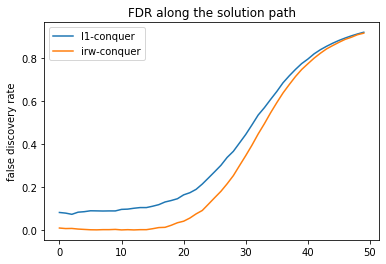

In [8]:
# FDR along the solution path
plt.plot(l1_fdr, label='l1-conquer')
plt.plot(irw_fdr, label='irw-conquer')
plt.title("FDR along the solution path")
plt.ylabel("false discovery rate")
plt.legend()

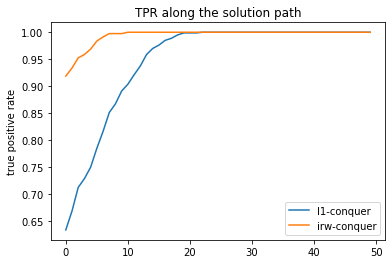

In [9]:
# TPR along the solution path
plt.plot(l1_tpr, label='l1-conquer')
plt.plot(irw_tpr, label='irw-conquer')
plt.title("TPR along the solution path")
plt.ylabel("true positive rate")
plt.legend()

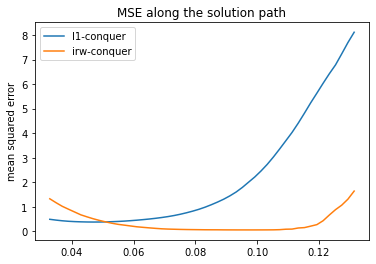

In [10]:
# MSE along the solution path
plt.plot(l1['lambda_seq'], np.mean(l1_sse, axis=1), label='l1-conquer')
plt.plot(l1['lambda_seq'], np.mean(irw_sse, axis=1), label='irw-conquer')
plt.title("MSE along the solution path")
plt.ylabel("mean squared error")
plt.legend()

### 2.3. Train ($\ell_1$, SCAD, MCP) penalized conquer on a validation set

$\ell_1$-conquer: $\ell_1$-penalized conquer;

scad-conquer: iteratively reweighted $\ell_1$-penalized conquer using SCAD-based weights;

mcp-conquer: iteratively reweighted $\ell_1$-penalized conquer using MCP-based weights;

oracle: conquer estimator fitted on the true model.

In [13]:
n_val = 128
nlambda, M = 50, 100
## [coef_se, model_size, true_pos, false_pos, lambda_min]
val_out = np.zeros(shape=(4, 5, M)) 
runtime = np.zeros(4)

for m in range(M):
    X_all = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n+n_val)
    Y_all = itcp + X_all.dot(beta) + rgt.standard_t(2,n+n_val) - spstat.t.ppf(tau,df=2)
    
    # training set of size n
    X, Y = X_all[:n, :], Y_all[:n]
    # validation set of size n_val
    X_val, Y_val = X_all[n:,:], Y_all[n:]
    sqr = validate_lambda(X, Y, X_val, Y_val, \
                          intercept=True, \
                          options={'warm_start': True})
    
    lam_max = np.max(high_dim(X, Y).self_tuning(tau))
    lambda_seq = np.linspace(0.25*lam_max, lam_max, num=nlambda)
    
    tic = time.time()
    l1 = sqr.train(tau=tau, lambda_seq=lambda_seq, \
                   order='descend', penalty="L1")
    runtime[0] +=  time.time() - tic
    
    tic = time.time()
    scad = sqr.train(tau=tau, lambda_seq=lambda_seq, \
                     order='descend', penalty="SCAD", a=3.7)
    runtime[1] +=  time.time() - tic
    
    tic = time.time()
    mcp = sqr.train(tau=tau, lambda_seq=lambda_seq, \
                    order='descend', penalty="MCP", a=3)
    runtime[2] +=  time.time() - tic   
    
    tic = time.time()
    ora = low_dim(X[:,true_set], Y).fit(tau=tau)
    runtime[3] += time.time() - tic 
    
    est = np.c_[(l1['val_beta'], scad['val_beta'],  mcp['val_beta'], np.zeros(p+1))]
    est[0,3], est[1:,3][beta!=0] =  ora['beta'][0], ora['beta'][1:]
    est = pd.DataFrame(est)
    
    # squared L2-error (coefficients)
    val_out[:,0,m] = (est.iloc[1:] - beta[:,None]).pow(2).sum(axis=0)
    # selected model size
    val_out[:,1,m] = est.iloc[1:].ne(0).sum(axis=0)
    # true positives
    val_out[:,2,m] = (est.iloc[1:].ne(0) * (beta!=0)[:,None]).sum(axis=0)
    # false positives
    val_out[:,3,m] = val_out[:,1,m] - val_out[:,2,m]
    # lambda_min (the value of lambda that gives minimum validation error)
    val_out[0,4,m] = l1['lambda_min']
    val_out[1,4,m] = scad['lambda_min']
    val_out[2,4,m] = mcp['lambda_min']

val_table = np.zeros((4, 7))
val_table[:,0] = np.mean(val_out[:,0,:], axis=1)
val_table[:,1] = np.std(val_out[:,0,:], axis=1)
val_table[:,2] = np.mean(val_out[:,1,:], axis=1)
val_table[:,3] = np.mean(val_out[:,2,:], axis=1)
val_table[:,4] = np.mean(val_out[:,3,:], axis=1)
val_table[:,5] = np.mean(val_out[:,4,:], axis=1)
val_table[:,6] = runtime/M

pd.DataFrame(val_table, columns=['coef_mse','(std)','size','TP','FP','lambda_min','runtime'],
             index=["l1-conquer", "scad-conquer","mcp-conquer","oracle"])

,coef_mse,(std),size,TP,FP,lambda_min,runtime
l1-conquer,0.392144,0.176043,52.44,8.0,44.44,0.046364,0.431443
scad-conquer,0.063977,0.048139,11.31,8.0,3.31,0.088890,2.014327
mcp-conquer,0.072325,0.061362,9.85,8.0,1.85,0.093469,2.099828
oracle,0.053140,0.039058,8.00,8.0,0.00,0.000000,0.002702


### 2.4. Cross-validated ($\ell_1$, SCAD, MCP) penalized conquer

In [14]:
nlambda, M = 50, 100
runtime = np.zeros(4)
cv_err = np.zeros([4, nlambda, M])
# [coef_se, model_size, true_pos, false_pos, lambda_min]
cv_out = np.zeros([4, 5, M])

for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    cv_sqr = cv_lambda(X, Y, intercept=True)
    
    tic = time.time()
    cv_l1 = cv_sqr.fit(tau=tau, nlambda=nlambda, \
                       penalty="L1", nfolds=8)
    runtime[0] +=  time.time() - tic
    
    tic = time.time()
    cv_scad = cv_sqr.fit(tau=tau, lambda_seq=cv_l1['lambda_seq'], \
                         penalty="SCAD", a=3.7, nfolds=8)
    runtime[1] +=  time.time() - tic
    
    tic = time.time()
    cv_mcp = cv_sqr.fit(tau=tau, lambda_seq=cv_l1['lambda_seq'], \
                        penalty="MCP", a=3, nfolds=8)
    runtime[2] +=  time.time() - tic
    
    tic = time.time()
    ora = low_dim(X[:,true_set], Y).fit(tau=tau)
    runtime[3] += time.time() - tic

    est = np.c_[(cv_l1['cv_beta'], cv_scad['cv_beta'], cv_mcp['cv_beta'], np.zeros(p+1))]
    est[0,3], est[1:,3][beta!=0] = ora['beta'][0], ora['beta'][1:]
    est = pd.DataFrame(est)

    # squared L2-error (coefficients)
    cv_out[:,0,m] = (est.iloc[1:] - beta[:,None]).pow(2).sum(axis=0)
    # selected model size
    cv_out[:,1,m] = est.iloc[1:].ne(0).sum(axis=0)
    # true positives
    cv_out[:,2,m] = (est.iloc[1:].ne(0) * (beta!=0)[:,None]).sum(axis=0)
    # false positives
    cv_out[:,3,m] = cv_out[:,1,m] - cv_out[:,2,m]
    # lambda_min (the value of lambda that gives minimum mean CV error)
    cv_out[:3,4,m] = np.array([cv_l1['lambda_min'], cv_scad['lambda_min'], cv_mcp['lambda_min']])
    # CV error
    cv_err[0,:,m] = cv_l1['cv_err']
    cv_err[1,:,m] = cv_scad['cv_err']
    cv_err[2,:,m] = cv_mcp['cv_err']
    
cv_table = np.zeros((4, 6))
cv_table[:,0] = np.mean(cv_out[:,0,:], axis=1)
cv_table[:,1] = np.std(cv_out[:,0,:], axis=1)
cv_table[:,2] = np.mean(cv_out[:,1,:], axis=1)
cv_table[:,3] = np.mean(cv_out[:,2,:], axis=1)
cv_table[:,4] = np.mean(cv_out[:,3,:], axis=1)
cv_table[:,5] = np.mean(cv_out[:,4,:], axis=1)
pd.DataFrame(cv_table, columns=['coef_mse','(std)','size','TP','FP','lambda_min'],
             index=["l1-conquer", "scad-conquer","mcp-conquer","oracle"])

,coef_mse,(std),size,TP,FP,lambda_min
l1-conquer,0.387157,0.146400,44.40,8.0,36.40,0.049187
scad-conquer,0.068895,0.058326,8.81,8.0,0.81,0.098901
mcp-conquer,0.078550,0.097344,8.52,8.0,0.52,0.105154
oracle,0.057993,0.039314,8.00,8.0,0.00,0.000000


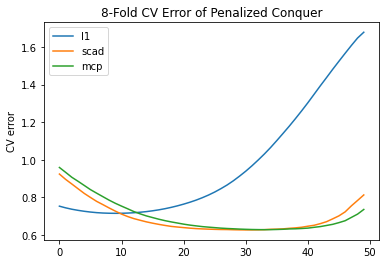

In [15]:
def cv_legend(y1, y2, y3):
    plt.clf()
    plt.plot(y1[::-1],label='l1')
    plt.plot(y2[::-1],label='scad')
    plt.plot(y3[::-1],label='mcp')
    plt.title("8-Fold CV Error of Penalized Conquer")
    plt.ylabel("CV error")
    plt.legend()
    
cv_legend(np.mean(cv_err[0,:,:], axis=1),
          np.mean(cv_err[1,:,:], axis=1),
          np.mean(cv_err[2,:,:], axis=1))

### 2.5. Model selection via Bayesian information criterion

In [19]:
M = 100
# [coef_se, model_size, true_pos, false_pos, bic_lambda]
bic_out = np.zeros([3, 5, M])

for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    sqr = high_dim(X, Y, intercept=True)
    bic_l1   = sqr.bic(tau=tau, penalty="L1")
    bic_scad = sqr.bic(tau=tau, penalty="SCAD")
    bic_mcp  = sqr.bic(tau=tau, penalty="MCP")

    est = pd.DataFrame(np.c_[(bic_l1['bic_beta'], 
                              bic_scad['bic_beta'], 
                              bic_mcp['bic_beta'])])
    # squared L2-error (coefficients)
    bic_out[:,0,m] = (est.iloc[1:] - beta[:,None]).pow(2).sum(axis=0)
    # selected model size
    bic_out[:,1,m] = est.iloc[1:].ne(0).sum(axis=0)
    # true positives
    bic_out[:,2,m] = (est.iloc[1:].ne(0) * (beta!=0)[:,None]).sum(axis=0)
    # false positives
    bic_out[:,3,m] = bic_out[:,1,m] - bic_out[:,2,m]
    # lambda_min (the value of lambda that gives minimum BIC)
    bic_out[:,4,m] = np.array([bic_l1['bic_lambda'], 
                               bic_scad['bic_lambda'], 
                               bic_mcp['bic_lambda']])

In [20]:
pd.DataFrame({"coef_mse": np.mean(bic_out[:,0,:], axis=1), \
              "(std)": np.std(bic_out[:,0,:], axis=1), \
              "model_size": np.mean(bic_out[:,1,:], axis=1), \
              "true_pos": np.mean(bic_out[:,2,:], axis=1), \
              "false_pos": np.mean(bic_out[:,3,:], axis=1), \
              "bic_lambda": np.mean(bic_out[:,4,:], axis=1)}, \
             index=["l1-bic", "scad-bic","mcp-bic"])

,coef_mse,(std),model_size,true_pos,false_pos,bic_lambda
l1-bic,0.890493,0.448207,9.82,8.0,1.82,0.078073
scad-bic,0.058635,0.039428,8.00,8.0,0.00,0.108389
mcp-bic,0.058639,0.039337,8.00,8.0,0.00,0.109140
